# Generate the Data

In [69]:
import matplotlib.pyplot as plt
import matplotlib
import cv2 as cv
import numpy as np
import usrLibraryUnsymmetrical as lib
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed

In [70]:
class optical_condition:
    L:      float # distance from the sample plane to the detector plane
    p:      float # pixel size of the detector
    Npixel: int   # window size of the probe function, object functions, and diffraction patterns
    energy: float # x-ray energy of the incident beam
    h:      float # plank constant
    c:      float # velocity of the light
    lamb:   float # wavelength
    k:      float # wavenumber
    dx:     float # pixel resolution at the sample plane
    DR:     float # dynamic range of the detector, for example opt.DR = log10{1e7 (photons) / 1 (photon}
    Wnoise: bool  # flag to apply photon shot noise to each calculated diffraction pattern


opt         = optical_condition()

opt.L       = 3                                         # unit: m
opt.p       = 75e-6                                     # unit: m
opt.Npixel  = 256                                      # unit: pixel
opt.energy  = 5000                                      # unit: eV (electronVolt)
opt.h       = 6.62607015e-34                            # unit: m^2 kg/s
opt.c       = 299792458                                 # unit: m/s
opt.lamb    = (opt.h * 6.242e18) * opt.c / opt.energy   # unit: m
opt.k       = 2 * np.pi / opt.lamb                      # unit: 1/m
opt.dx      = opt.L * opt.lamb / (opt.Npixel * opt.p)   # unit: m/pixel
opt.DR      = 7
opt.Wnoise  = True

In [79]:
class aperture_condition:
    width:              float
    height:             float
    Lpropagation:       float   # distance from the aperture to the sample
    needPropagation:    bool    # flag whether propagation from the aperture to the sample is needed

aper = aperture_condition()

aper.width          = 5e-6
aper.height         = 5e-6     #5e-7  # unit: m
aper.Lpropagation   = 0     # unit: m, range: # 500-1000*10^-6

if aper.Lpropagation > 0:
    aper.needPropagation = True
else:
    aper.needPropagation = False

In [80]:
class particle_condition:
    beta_Au:    float # parameter related to the absorption of the wavefield
    delta_Au:   float # parameter related to the phase shift of the wavefield
    diameter:   float # diameter of the gold nanoparticle
    ratio:      float # (Area occupied with gold nanoparticles) / (Area of the window, Npixel x Npixel)
    number:     int   # total number of the gold nanoparticles within the window
    velocity:   float # displacement of the gold nanoparticles (per frame)

par = particle_condition()

par.beta_Au     = 2.633e-5
par.delta_Au    = 1.2143e-4
par.diameter    = 150e-9 #300e-9 # unit: m
par.ratio       = 100e-3
par.number      = int(np.floor((opt.Npixel * opt.dx)**2 / (np.pi * (par.diameter / 2)**2) * par.ratio))
par.Nframe      = 11
par.velocity    = 1 * opt.dx    # unit: m/frame

In [81]:
# set different seed per n frame
np.random.seed(1)

aperture = lib.calcRectangleAperture(opt, aper)
smooth_aperture = cv.GaussianBlur(aperture, (9,9), 0)
if aper.needPropagation == 1:
    inwave = lib.angularSpectrum(smooth_aperture, opt, aper)
else:
    inwave = aperture

AuNPimg = lib.calcAuNP(opt, par)

wavesample = AuNPimg * np.tile(inwave[:, :, np.newaxis], (1, 1, par.Nframe))
wavedetector = np.fft.fftshift(np.fft.fft2(wavesample, axes = (0, 1)), axes = (0, 1))

difImg       = np.abs(wavedetector)**2

# diffraction patterns are normalized so that its dynamic range become "opt.DR"
maxCount     = difImg.max()
difImg       = difImg / maxCount * 10**(opt.DR)
isCounted    = np.where(difImg >= 1, 1, 0)
difImg       = difImg * isCounted # pixels which count lower than 1 photon is set to 0

# 2-4-3, apply photon shot noise if "opt.Wnoise" is True
if opt.Wnoise == 1:
    difImgWnoise = np.random.poisson(difImg)

0
1
2
3
4
5
6
7
8
9
10


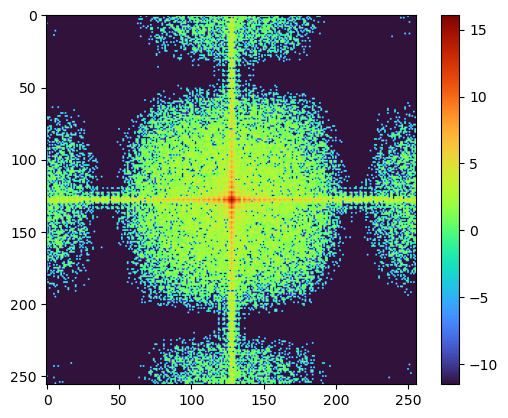

In [82]:
plt.imshow(np.log(np.abs(difImg[:,:,0]+1e-5)), cmap='turbo')
plt.colorbar()

# HIO

In [83]:
diff = np.abs(wavedetector[:,:,0])

# Initial guess using random phase info
guess = diff * np.exp(1j * np.random.rand(opt.Npixel,opt.Npixel) * np.pi)

# number of iteration
r = 10000

# step size parameter
beta = 0.5
alpha = 0.6

# Previous result
prev_abs = None
prev_phase = None

support_mask = (aperture == 0)
region_mask = (aperture == 1)

for s in range(0,r):
    #apply fourier domain constraints
    update = diff * np.exp(1j * np.angle(guess)) 
    
    inv = np.fft.ifft2(np.fft.ifftshift(update))
    inv_abs = np.real(inv)
    inv_phase = np.angle(inv)

    if prev_abs is None:
        prev_abs = inv_abs
        prev_phase = inv_phase

    #apply real-space constraints
    temp_abs = inv_abs
    temp_phase = inv_phase
    if s > 100:
        cond = (inv_abs < 0)
    else:
        cond = (inv_abs > 1)
        
    abs_mask = cond  & region_mask
    inv_abs[abs_mask] = prev_abs[abs_mask] - alpha * inv_abs[abs_mask]
    inv_abs[support_mask] = prev_abs[support_mask] - alpha * inv_abs[support_mask]
        
    phase_mask = (inv_phase > 0) & region_mask
    inv_phase[phase_mask] = prev_phase[phase_mask] - beta * inv_phase[phase_mask]
    inv_phase[support_mask] = prev_phase[support_mask] - beta * inv_phase[support_mask]
    
    prev_abs = temp_abs
    prev_phase = temp_phase
    
    #inv = inv_abs*np.exp(1j*inv_phase)
    inv = inv_abs + 1j * (np.tan(inv_phase)*inv_abs)
    guess =  np.fft.fftshift(np.fft.fft2(inv*inwave))
        
    if s % 50 == 0:
        print(s)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950


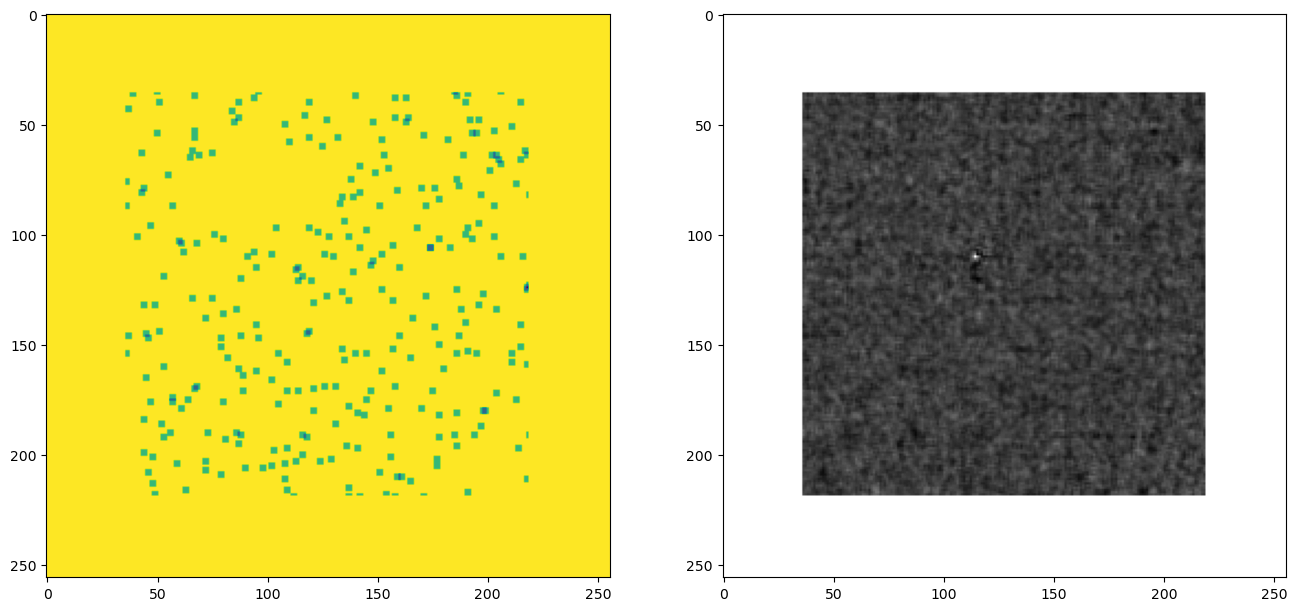

In [84]:
fig = plt.figure(figsize = [16, 8])

ax = plt.subplot(1,2,1)
im = plt.imshow(np.angle(AuNPimg[:,:,0])*aperture,vmax=0)

ax2 = plt.subplot(1,2,2)
im = plt.imshow(np.angle(inv)*aperture,cmap='gray',vmax=0)

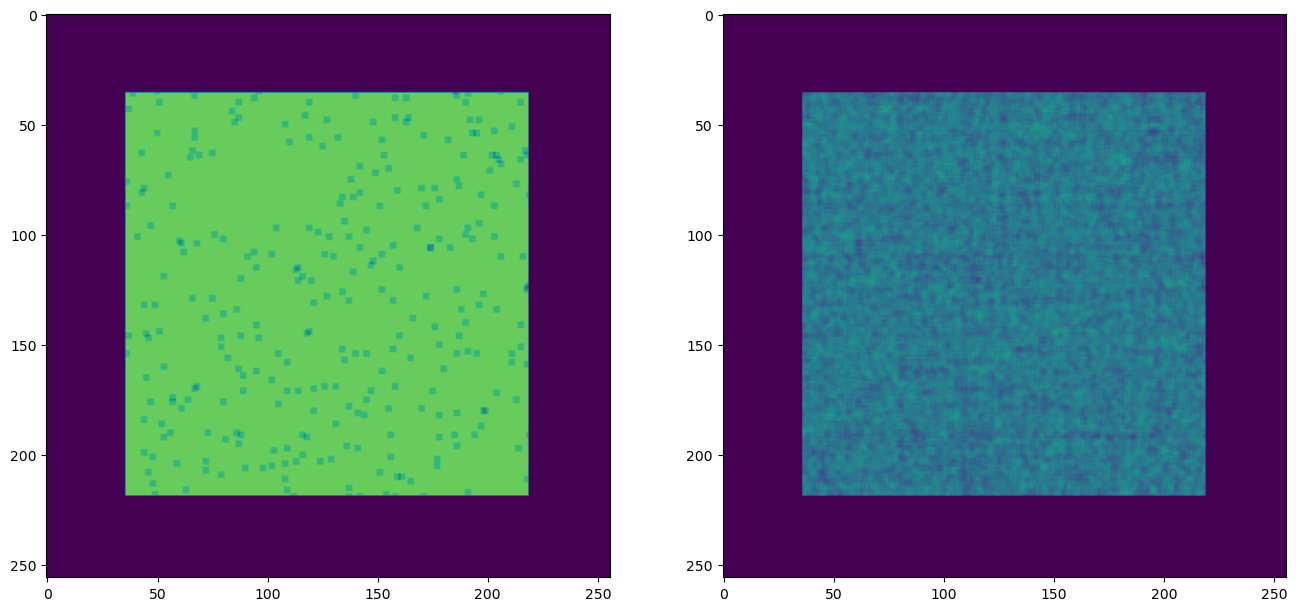

In [85]:
fig = plt.figure(figsize = [16, 8])

ax = plt.subplot(1,2,1)
im = plt.imshow(np.real(AuNPimg[:,:,0])*aperture,vmax=1.3)

ax2 = plt.subplot(1,2,2)
im = plt.imshow(np.real(inv)*aperture,vmax=1.3)

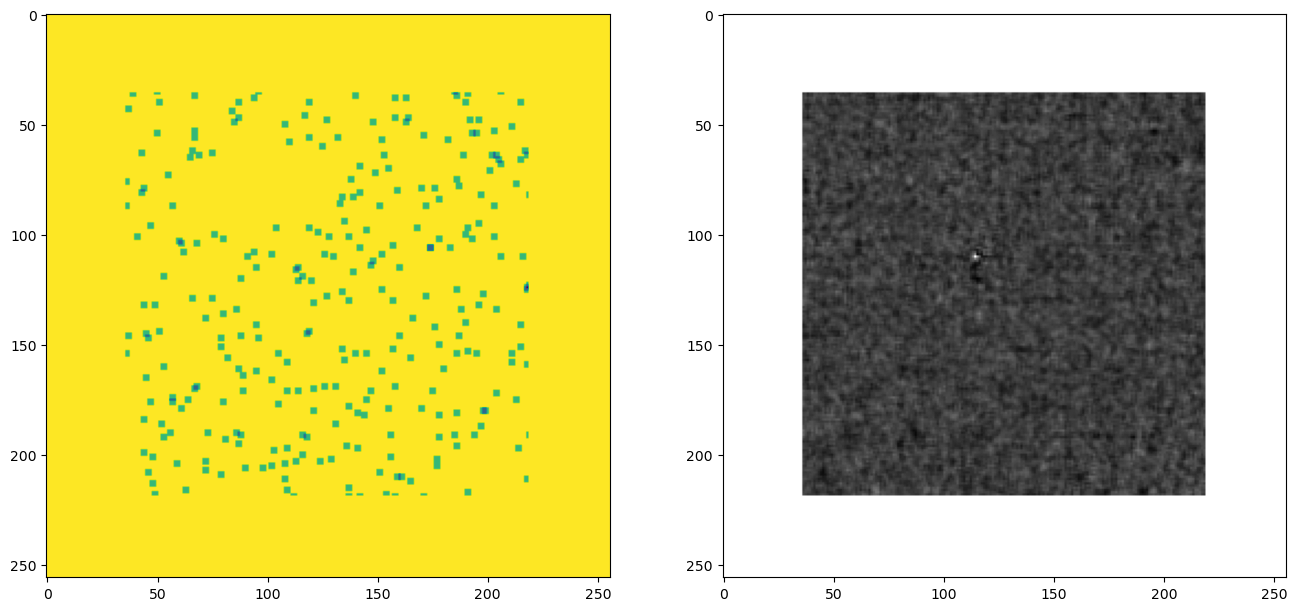

In [86]:
fig = plt.figure(figsize = [16, 8])

ax = plt.subplot(1,2,1)
im = plt.imshow(np.angle(AuNPimg[:,:,0])*aperture,vmax=0)

ax2 = plt.subplot(1,2,2)
im = plt.imshow(np.angle(inv)*aperture,cmap='gray',vmax=0)